<a href="https://colab.research.google.com/github/rkoprik/txs_graph/blob/main/SoChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transaction data


https://chain.so/

In [6]:
# import packages
import requests
import tabulate
import pandas as pd
import networkx as nx
import numpy as np
 
 
# 682950 - 683238: 11/05/2021 
# 683094 - initial example
 
# range block
block_range = list(range(683093, 683098))
 
r1 = 0
r2 = 2
size_block = range(r1, r2)
 
# transaction info
transaction_id = []
input_address = []
input_value = []
output_address = []
output_value = []
date = []
 
# range transaction
r3 = 0
r4 = len(txs)
size = range(r3, r4)
 
for y in size_block:
 
  # transaction link
  link_block = 'https://chain.so/api/v2/get_block/BTC/' + str(block_range[y])
 
  response = requests.get(link_block)
 
  if response.status_code == 200:
      # everything went swimmingly                                                                                                                   
      # parse the response as JSON
      content = response.json()
      
      # transaction id
      txs = content['data']['txs']
 
  for x in size:
 
    # transaction link
    link_txs = 'https://chain.so/api/v2/tx/BTC/' + str(txs[x])
 
    response = requests.get(link_txs)
 
      
    if response.status_code == 200:
          # everything went swimmingly parse the response as JSON
          content = response.json()
 
          # transaction_id
          transaction_id.append(content['data']['txid'])
          
          # input leg
          for each in content['data']['inputs']:
            input_address.append(each['address'])
            input_value.append(each['value'])
 
          # output leg
          for each in content['data']['outputs']:
            output_address.append(each['address'])
            output_value.append(each['value'])
 
          # date
          date.append(content['data']['time'])
          # time = content['data']['time']
          # date.append(time)
 
          largest = max(len(transaction_id), len(input_address), len(input_value), len(output_address), len(output_value))
 
    len_transaction_id = largest - len(transaction_id)
    len_input_address = largest - len(input_address)
    len_output_address = largest - len(output_address)
    len_date = largest - len(date)
 
    corr_transaction_id = [None]*len_transaction_id
    corr_input_address = [None]*len_input_address
    corr_output_address = [None]*len_output_address
    corr_date = [None]*len_date
 
    transaction_id.extend(corr_transaction_id)
    input_address.extend(corr_input_address)
    input_value.extend(corr_input_address)
    output_address.extend(corr_output_address)
    output_value.extend(corr_output_address)
    date.extend(corr_date)
 
df_01 = pd.DataFrame({'transaction_id': transaction_id, 'from': input_address, 'tt_value': input_value, 'to': output_address, 'amount': output_value, 'date': date})
 
 
#clean data
  # obmit nulldata & reindex
df= df_01[df_01.to != "nulldata"]
df.reset_index(drop=True, inplace=True)
 
 
 # fill NaN with previous data for all NaN, None
df.date = df.date.fillna(method = 'ffill')
df = df.fillna(value=np.nan)
df

KeyboardInterrupt: ignored

NOTE!
We need to be aware of the following different transaction types:
Newly generated coins, identifiable via the participating address "coinbase!

Indicators

In [3]:
# Indicators

# Edge to vertex ratio
  # number of edges/number of vertices

df_counts = df.count()
#np.sum(df.count())


n_edges = len(txs)
n_edges

edge_vertices = n_vertices/n_edges
edge_vertices

to_from = df['to'].notnull().sum()/df['from'].notnull().sum()
to_from

# df_indices = pd.DataFrame(n_vertices, columns = ['n_vertices', 'n_edges'])
# df_indices

n_vertices = df['from'].notnull().sum() + df['to'].notnull().sum()
n_vertices

NameError: ignored

,amount,from,to,transaction_id,tt_value,vertices
date,,,,,,
1.620731e+09,10,3,10,3,3,13
1.620731e+09,5,3,5,3,3,8


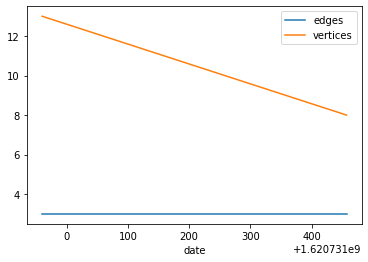

In [ ]:
# summarizes df
df_solution = df.pivot_table(index=['date'], aggfunc='count')
# creates new var with vertices
df_solution['vertices'] = df_solution['to'] + df_solution['from']
# consolidated edges and vertices data 
df_egd_vert = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices})
# plot
df_egd_vert.plot()
df_solution

Plotting

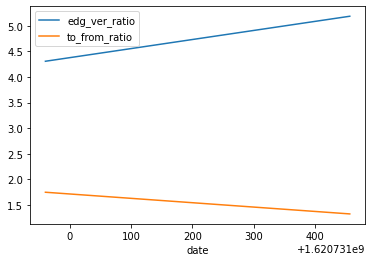

In [ ]:
# creates new col with edge to vert ratio
df_solution['edg_ver_ratio'] = df_solution['vertices'] / df_solution['transaction_id']
# creates new col with to from ratio
df_solution['to_from_ratio'] = df_solution['to'] / df_solution['from']
# creates dataframe
df_ratios = pd.DataFrame({'edg_ver_ratio': df_solution.edg_ver_ratio, 'to_from_ratio': df_solution.to_from_ratio})
# plot
df_ratios.plot()

In [ ]:
# consolidated data with ratios
df_indicators = pd.DataFrame({'edges': df_solution.transaction_id, 'vertices': df_solution.vertices, 'edg_ver_ratio': df_solution.edg_ver_ratio, 'to_from_ratio': df_solution.to_from_ratio})
df_indicators

,edges,vertices,edg_ver_ratio,to_from_ratio
date,,,,
1.620731e+09,2687,11570,4.305917,1.750832
1.620731e+09,2681,13898,5.183887,1.327973


In [ ]:
  # Next steps
    # Fix date issue - extend solution for all obs
    # Get number of blocks for first for y - maybe start with a week? maybe a day?
    # Data cleaning and preparing - 3 columns: date, n_edges, n_vertices
    # Time measures for Monthly TG and Cumulative Monthly TG
    # Network measures - clustering, density, edge-to-vertex ratio, repetition, etc.

# **TESTS**

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------

# time series

# Aggregates data 
# df_solution = df.pivot_table(index=['date'], aggfunc='count')
# df_solution.plot()


# import plotly.express as px
# fig = px.histogram(df, x = 'date', y = 'transaction_id')
# fig.show()

import plotly.express as px
fig = px.line(df_indicators, x = 'date', y = 'edges')
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(df, x = 'date', y = df['from'].notnull().sum() + df['to'].notnull().sum())
fig.show()

Create Network / Transaction graph

In [ ]:
# Network Graph
G = nx.from_pandas_edgelist(df, source='from', target='to')
nx.draw_random(G, node_size = 50)

# ------------------------------------------------------------------------------
# Jaal
  # Jaal(edge_df).plot()

          # https://towardsdatascience.com/introducing-jaal-interacting-with-network-made-easy-124173bb4fa
          # edge_df: it's a pandas dataframe with at least from and to columns, which represents the edge relationship between the entities
          # node_df: it's a pandas dataframe with at least id column which contains the unique node names     

# ------------------------------------------------------------------------------

# NetworkX         
    # https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb
    # https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259



In [ ]:
import pyvis
from pyvis.network import network
net = Network(notebook=True)
net.from_nx(G)
net.show("---")

In [ ]:
import requests
date_test = []

response = requests.get('https://chain.so/api/v2/tx/BTC/3f01afaa5bc4460e49edddebd645477f59d88f1056987558c8717f5cf3529450')

if response.status_code == 200:
    # everything went swimmingly                                                                                                                   
    # parse the response as JSON
    content = response.json()

    date_test.append(int(content['data']['time']))

date_test
# Tue May 11 11:10:57 2021

[1620731681]

In [ ]:
# converting epoch time

import datetime

date_test = []

for each in len(df.date):
  date_test.extend(datetime.datetime.fromtimestamp(df.date[each]).strftime('%c'))
date_test

TypeError: ignored

In [ ]:
#clean data
  # obmit nulldata & reindex
# df = df_01[df_01.to != "nulldata"]
# df.reset_index(drop=True, inplace=True)

 # fill NaN with previous data for all NaN, None
# df = df.fillna(method = 'ffill')
# df

# converting epoch time

# dictionary with column name and data type
data_types_dict = {'date': int}
df = df.astype(data_types_dict)
  
# datetime.datetime.fromtimestamp(df.date).strftime('%c')
